In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import InputLayer, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

import time

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Bell_Amundsen_Extent = pd.read_excel(filepath, sheet_name='Bell-Amundsen-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Bell_Amundsen_Extent)
fp.date_time(Bell_Amundsen_Extent)

,Extent,Date
0,1179855.894,1979-01-01
1,879585.254,1979-02-01
2,791619.096,1979-03-01
3,1254912.071,1979-04-01
4,1620142.247,1979-05-01
...,...,...
533,1556568.455,2023-06-01
534,1917507.979,2023-07-01
535,2601630.327,2023-08-01
536,2534223.780,2023-09-01


In [5]:
scaler = MinMaxScaler()
Bell_Amundsen_Extent['Extent'] = scaler.fit_transform(Bell_Amundsen_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 2
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Bell_Amundsen_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((525, 12, 1), (525,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(Bidirectional(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0))))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Bell_Amund_model_LT2/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 39s 516ms/step - loss: 0.1790 - root_mean_squared_error: 0.4231 - val_loss: 0.0968 - val_root_mean_squared_error: 0.3112
Epoch 2/50
53/53 [==============================] - 25s 484ms/step - loss: 0.0574 - root_mean_squared_error: 0.2396 - val_loss: 0.0734 - val_root_mean_squared_error: 0.2709
Epoch 3/50
53/53 [==============================] - 25s 475ms/step - loss: 0.0454 - root_mean_squared_error: 0.2131 - val_loss: 0.0572 - val_root_mean_squared_error: 0.2392
Epoch 4/50
53/53 [==============================] - 26s 507ms/step - loss: 0.0323 - root_mean_squared_error: 0.1797 - val_loss: 0.0397 - val_root_mean_squared_error: 0.1993
Epoch 5/50
53/53 [==============================] - 26s 502ms/step - loss: 0.0207 - root_mean_squared_error: 0.1437 - val_loss: 0.0258 - val_root_mean_squared_error: 0.1606
Epoch 6/50
53/53 [==============================] - 27s 511ms/step - loss: 0.0148 - root_mean_squared_error: 0.1217 - val_loss: 0.0219 

53/53 [==============================] - 12s 227ms/step - loss: 0.0090 - root_mean_squared_error: 0.0950 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1197
Epoch 33/50
53/53 [==============================] - 3s 52ms/step - loss: 0.0093 - root_mean_squared_error: 0.0963 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1204
Epoch 34/50
53/53 [==============================] - 15s 293ms/step - loss: 0.0089 - root_mean_squared_error: 0.0942 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1194
Epoch 35/50
53/53 [==============================] - 25s 482ms/step - loss: 0.0098 - root_mean_squared_error: 0.0989 - val_loss: 0.0141 - val_root_mean_squared_error: 0.1188
Epoch 36/50
53/53 [==============================] - 3s 65ms/step - loss: 0.0088 - root_mean_squared_error: 0.0938 - val_loss: 0.0150 - val_root_mean_squared_error: 0.1223
Epoch 37/50
53/53 [==============================] - 3s 65ms/step - loss: 0.0092 - root_mean_squared_error: 0.0957 - val_loss: 0.0141 - val_root_m

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

11.998334701855978 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

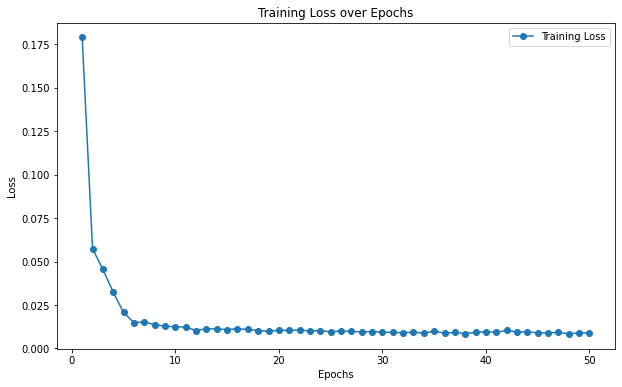

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

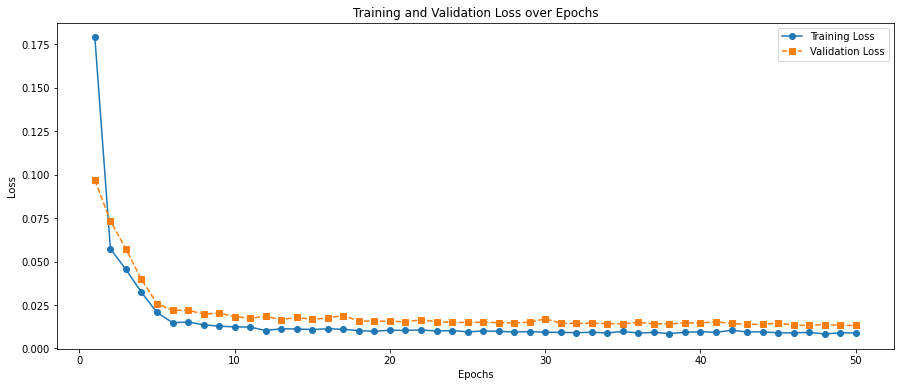

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Bell_Amund_model_LT2/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 2s 38ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.09836079080726297
MAE : 0.07973281085371753


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,1.726855e+06,1575894.445
1,2.082058e+06,1714381.703
2,2.268723e+06,2067343.547
3,2.315249e+06,1856673.675
4,2.154168e+06,1914289.680
5,1.857891e+06,1802244.842
6,1.430707e+06,1202791.069
7,8.267661e+05,752834.272
8,4.978126e+05,451914.219
9,5.498468e+05,439855.813


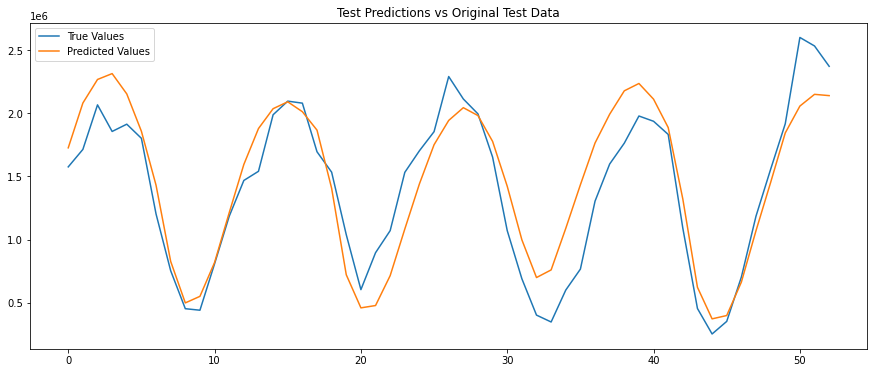

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 1s 43ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

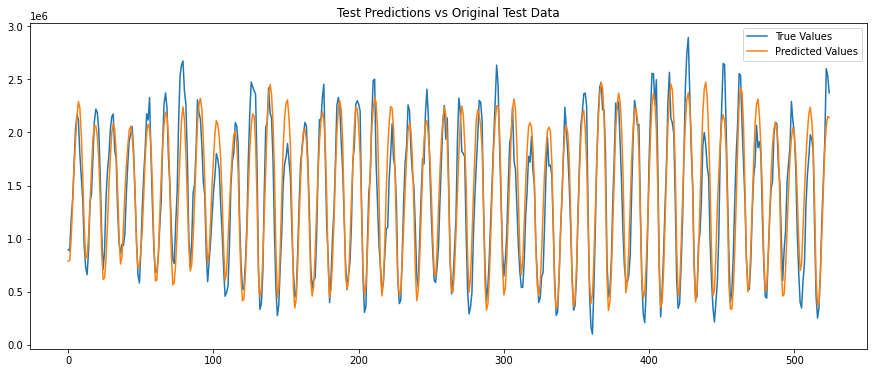

In [24]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()